In [1]:
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
import argparse
from sklearn import metrics
from tqdm.notebook import tqdm
import gc
import shutil 

In [2]:
%%time
FILE_PATH = '../input/grasp-and-lift-eeg-detection'
list_dir = os.listdir(FILE_PATH)

for zipfile in list_dir:
    with ZipFile(os.path.join(FILE_PATH, zipfile), 'r') as z:
        z.extractall()

CPU times: user 23.9 s, sys: 3.97 s, total: 27.8 s
Wall time: 36.3 s


In [3]:
labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']

In [4]:
torch.manual_seed(2021)
np.random.seed(2021)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=1024, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.005, help="adam's learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.99, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=4, help="number of cpu threads to use during batch generation")
parser.add_argument("--in_len", type=int, default=2**10, help="length of the input fed to neural net")
parser.add_argument("--in_channels", type=int, default=32, help="number of signal channels")
parser.add_argument("--out_channels", type=int, default=6, help="number of classes")
parser.add_argument("--chunk", type=int, default=1000, help="length of splited chunks")
opt, unknown = parser.parse_known_args()
print(device)

cuda:0


In [5]:
%%time
def read_csv(data, events):
    x = pd.read_csv(data)
    y = pd.read_csv(events)
    id = '_'.join(x.iloc[0, 0].split('_')[:-1])
    x = x.iloc[:,1:].values
    y = y.iloc[:,1:].values
    return x, y
    

trainset = []
gt = []
for filename in tqdm(os.listdir('./train')):
    if 'data' in filename:
        data_file_name = os.path.join('./train', filename)
        id = filename.split('.')[0]
        events_file_name = os.path.join('./train', '_'.join(id.split('_')[:-1]) + '_events.csv')
        x, y = read_csv(data_file_name, events_file_name)
        trainset.append(x.T.astype(np.float32))
        gt.append(y.T.astype(np.float32))

  0%|          | 0/192 [00:00<?, ?it/s]

CPU times: user 1min 13s, sys: 5.67 s, total: 1min 18s
Wall time: 1min 19s


In [6]:
valid_dataset = trainset[-2:]
valid_gt = gt[-2:]
trainset = trainset[:-2]
gt = gt[:-2]

In [7]:
def resample_data(gt, chunk_size=opt.chunk):
    """
    split long signals to smaller chunks, discard no-events chunks  
    """
    total_discard_chunks = 0
    mean_val = []
    threshold = 0.01
    index = []
    
    for i in range(len(gt)):
        for j in range(0, gt[i].shape[1], chunk_size):
            mean_val.append(np.mean(gt[i][:, j:min(gt[i].shape[1],j+chunk_size)]))
            if mean_val[-1] < threshold and j > 0:  # discard chunks with low events time
                total_discard_chunks += 1
                index.extend([(i, k) for k in range(j, min(gt[i].shape[1],j+chunk_size), chunk_size//100)])
            else:
                index.extend([(i, k) for k in range(j, min(gt[i].shape[1],j+chunk_size))])

    plt.plot([0, len(mean_val)], [threshold, threshold], color='r')
    plt.scatter(range(len(mean_val)), mean_val, s=1)
    plt.show()
    print('Total number of chunks discarded: {} chunks'.format(total_discard_chunks))
    print('{}% data'.format(total_discard_chunks/len(mean_val)))
    del mean_val
    gc.collect()
    return index

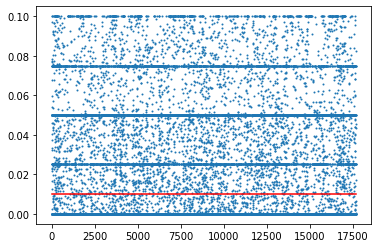

Total number of chunks discarded: 8666 chunks
0.49043576683644596% data
9866344
CPU times: user 2.47 s, sys: 582 ms, total: 3.05 s
Wall time: 3.09 s


In [8]:
%%time
class EEGSignalDataset(Dataset):
    def __init__(self, data, gt, soft_label=True, train=True):
        self.data = data
        self.gt = gt
        self.train = train
        self.soft_label = soft_label
        if train:
            self.index = resample_data(gt)
        else:
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
    
    def __getitem__(self, i):
        i, j = self.index[i]
        raw_data, label = self.data[i][:,max(0, j-opt.in_len+1):j+1], \
                self.gt[i][:,j]
        
        pad = opt.in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        if self.soft_label:
            label[label < .05] = .05
        return raw_data, label
            
    
    def __len__(self):
        return len(self.index)
    
dataset = EEGSignalDataset(trainset, gt) 
dataloader = DataLoader(dataset, batch_size = opt.batch_size,\
                                       num_workers = opt.n_cpu, shuffle=True)
print(len(dataset))

In [9]:
class NNet(nn.Module):
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.out_channels):
        super(NNet, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
            nn.BatchNorm1d(opt.in_channels),
            nn.Conv1d(opt.in_channels, opt.in_channels, 5, padding=2),
            nn.Conv1d(self.hidden, self.hidden, 16, stride=16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        for i in range(2):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden)) # 16
        
        self.mid = nn.Sequential(
            self.__block(self.hidden, self.hidden),
            self.__block(self.hidden, self.hidden)
        ) # 4
        self.final = nn.Sequential(
            nn.Linear(256, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 6),
            nn.Sigmoid()
        )
        
    def __block(self, inchannels, outchannels):
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(outchannels),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1)
        )
    
    def forward(self, x):
        x = self.net(x)
        y = self.mid(x)
        y = torch.cat((x[..., -4:], y), dim=-1).view(x.shape[0], -1)
        return self.final(y)

In [10]:
testset = EEGSignalDataset(valid_dataset, valid_gt, train=False, soft_label=False) 
testloader = DataLoader(testset, batch_size = opt.batch_size,\
                                       num_workers = opt.n_cpu, shuffle=False)
valid_gt = np.concatenate(valid_gt, axis=1)

# Train

In [11]:
def calc_valid_auc(nnet):
    nnet.eval()
    y_pred = []
    with torch.no_grad():
        for x, _ in testloader:
            x = x.to(device)
            pred = nnet(x).detach().cpu().numpy()
            y_pred.append(pred)
    
    y_pred = np.concatenate(y_pred, axis=0)
    return metrics.roc_auc_score(valid_gt.T, y_pred)

In [12]:
nnet = NNet()
nnet.to(device)
loss_fnc = nn.BCELoss()
adam = optim.Adam(nnet.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
loss_his, train_loss, valid_auc, train_auc = [], [], [], []
nnet.train()
for epoch in range(opt.n_epochs):
    p_bar = tqdm(dataloader)
    for i, (x, y) in enumerate(p_bar):
        x, y = x.to(device), y.to(device)
        pred = nnet(x)
        loss = loss_fnc(pred.squeeze(dim=-1), y)
        adam.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(nnet.parameters(), 2.)
        adam.step()
        train_loss.append(loss.item())
        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        if i % 50 == 0:
            loss_his.append(np.mean(train_loss))
            train_loss.clear()

    print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, opt.n_epochs, loss_his[-1]))
    
torch.save(nnet.state_dict(), 'model.pt')

  0%|          | 0/9636 [00:00<?, ?it/s]

[Epoch 1/1] [Loss: 0.23916853576898575]


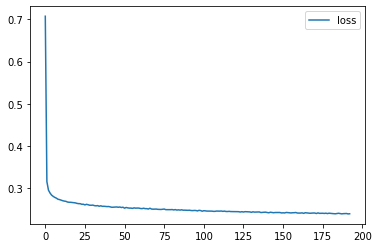

In [13]:
plt.plot(range(len(loss_his)), loss_his, label='loss')
plt.legend()
plt.show()

# Test on validset

In [14]:
nnet.eval()
y_pred = []
with torch.no_grad():
    for x, _ in tqdm(testloader):
        x = x.to(device)
        pred = nnet(x).detach().cpu().numpy()
        y_pred.append(pred)
        

  0%|          | 0/351 [00:00<?, ?it/s]

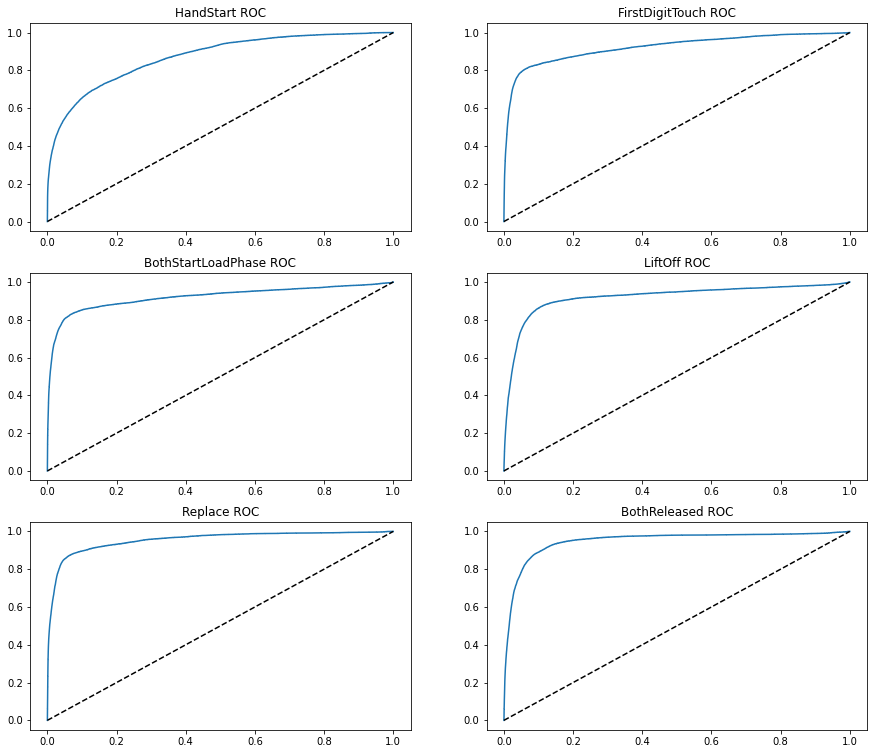

auc roc:  0.9223282276756178


In [15]:
def plot_roc(y_true, y_pred):
    fig, axs = plt.subplots(3, 2, figsize=(15,13))
    for i, label in enumerate(labels):
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        ax = axs[i//2, i%2]
        ax.plot(fpr, tpr)
        ax.set_title(label+" ROC")
        ax.plot([0, 1], [0, 1], 'k--')

    plt.show()
    
y_pred = np.concatenate(y_pred, axis=0)
plot_roc(valid_gt, y_pred.T)
print('auc roc: ', metrics.roc_auc_score(valid_gt.T, y_pred))

In [16]:
del y_pred
del testset
del testloader
del valid_dataset
del valid_gt
gc.collect()

21109

In [17]:
i = 1231
with torch.no_grad():
    input = dataset[i][0].unsqueeze(dim=0)
    print(nnet(input.to(device)))
    print(dataset[i][1])

tensor([[0.1881, 0.0458, 0.0433, 0.0501, 0.0471, 0.0568]], device='cuda:0')
tensor([1.0000, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500])


In [18]:
del dataset
del dataloader
del trainset
del gt
gc.collect()

40

# Create submission

In [19]:
class EEGSignalTestset(Dataset):
    def __init__(self, data):
        self.data = data
        self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
    
    def __getitem__(self, i):
        i, j = self.index[i]
        raw_data = self.data[i][:,max(0, j-opt.in_len+1):j+1]
        
        pad = opt.in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data = torch.from_numpy(raw_data.astype(np.float32))
        return raw_data
            
    
    def __len__(self):
        return len(self.index)


In [20]:
%%time
testset = []
trial_len = {}
FNAME = "./test/subj{}_series{}_{}.csv"

for subj in range(1,13):
    for series in [9, 10]:
        data_file_name = FNAME.format(subj, series, 'data')
        x = pd.read_csv(data_file_name).iloc[:,1:].values
        testset.append(x.T.astype(np.float32))
        trial_len['{}_{}'.format(subj, series)] = testset[-1].shape[-1]
        

CPU times: user 10.4 s, sys: 523 ms, total: 10.9 s
Wall time: 11.6 s


In [21]:
testset = EEGSignalTestset(testset)
dataloader = DataLoader(testset, batch_size = opt.batch_size,\
                                       num_workers = opt.n_cpu, shuffle=False)

In [22]:
y_pred = []
with torch.no_grad():
    for x in tqdm(dataloader):
        x = x.to(device)
        pred = nnet(x).detach().cpu().numpy()
        y_pred.append(pred)
        
y_pred = np.concatenate(y_pred, axis=0)

  0%|          | 0/3071 [00:00<?, ?it/s]

In [23]:
%%time
submission = pd.DataFrame(y_pred, index=\
    ['subj{}_series{}_{}'.format(sbj, i, j) for sbj in range(1,13) for i in [9,10] for j in range(trial_len['{}_{}'.format(sbj, i)])],\
                         columns=labels)
submission.to_csv('Submission.csv',index_label='id',float_format='%.3f')

CPU times: user 47.5 s, sys: 923 ms, total: 48.4 s
Wall time: 48.6 s


In [24]:
a = pd.read_csv('Submission.csv')
a.tail()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
3144166,subj12_series10_142195,0.206,0.038,0.037,0.042,0.036,0.041
3144167,subj12_series10_142196,0.225,0.038,0.036,0.042,0.036,0.041
3144168,subj12_series10_142197,0.247,0.037,0.037,0.042,0.036,0.040
3144169,subj12_series10_142198,0.255,0.037,0.037,0.041,0.036,0.040
3144170,subj12_series10_142199,0.279,0.037,0.037,0.041,0.035,0.039


In [25]:
try:
    shutil.rmtree('./train')
    shutil.rmtree('./test')
    os.remove('sample_submission.csv')
except:
    pass

In [26]:
df=pd.read_csv('/kaggle/working/Submission.csv')
df.to_csv('Submission.csv',index = False)